# 코스피와 장단기 금리차, 선행지수 순환변동치와의 관계 분석


Kospi 를 예측할 수 있는 Feature를 살펴보고, 실제 수익이 날 수 있는 2023년이 되길 !  

Feature 로는 선행지수 순환변동치, 동행지수 순환변동치, 10년물 국고채 금리, 3년물 국고채 금리가 사용되었다. 이는 김영익 교수님이 자주 사용하시는 지표라 그대로 통계청에서 가지고 왔다.  

사용된 데이터 출처:
1. [통계청, 국고채 금리](https://ecos.bok.or.kr/#/Short/54912b)  
2. [통계청, 경기종합지수](https://ecos.bok.or.kr/#/Short/d341d7)
3. [코스피, 인베스팅닷컴](https://kr.investing.com/indices/kospi-historical-data)


### Load libraries

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import copy
plt.style.use('seaborn')

### Load data 

편의를 위해 dataframe으로 데이터를 관리한다.   
필요없는 데이터는 지우고, 시간순으로 배열한다.

In [83]:
business_indicators = pd.read_csv('../data/경기종합지수_11101516.csv')
business_indicators = business_indicators.transpose()
business_indicators = business_indicators.drop(index=['통계표', '계정항목', '단위', '변환'])
business_indicators.columns = ['선행지수순환변동치', '동행지수순환변동치']
business_indicators.index = pd.to_datetime(business_indicators.index)
business_indicators['선행지수순환변동치'] = business_indicators['선행지수순환변동치'].astype(float)
business_indicators['동행지수순환변동치'] = business_indicators['동행지수순환변동치'].astype(float)
business_indicators = business_indicators.sort_index()


market_rate = pd.read_csv('../data/시장금리(월,분기,년)_11101525.csv')
market_rate = market_rate.transpose()
market_rate = market_rate.drop(index=['통계표', '계정항목', '단위', '변환'])
market_rate.columns = ['3year', '10year']
market_rate.index = pd.to_datetime(market_rate.index)
market_rate['3year'] = market_rate['3year'].astype(float)
market_rate['10year'] = market_rate['10year'].astype(float)
market_rate['10year-3year'] = market_rate['10year'] - market_rate['3year']
market_rate = market_rate.drop(columns=['3year', '10year'])
market_rate = market_rate.sort_index()


kospi = pd.read_csv('../data/코스피지수 내역.csv')
kospi['날짜'] = pd.to_datetime(kospi['날짜'])
kospi.index = kospi['날짜']
kospi = kospi.drop(columns=['날짜', '오픈', '고가', '저가', '거래량', '변동 %'])
#kospi['종가'] = pd.to_numeric(kospi['종가'])
kospi = kospi.sort_index()

business_indicators

###  탐색적 데이터 분석 (EDA, Exploratory Data Analysis)

#### 코스피와 경기종합지수 관계 

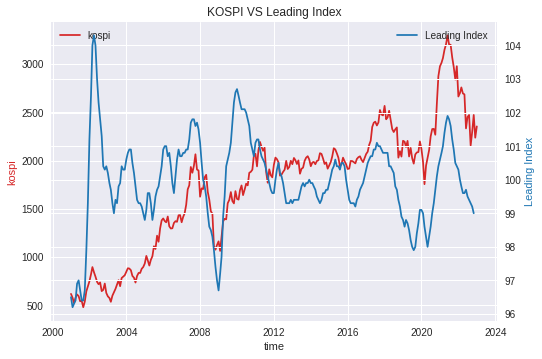

In [84]:
#%%
f, ax = plt.subplots(1, 1)
color = 'tab:red'
ax.plot(kospi.index, kospi['종가'], color=color, label='kospi')
ax.set_ylabel('kospi', color=color)
ax.set_xlabel('time')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
# we already handled the x-label with ax1
ax2.set_ylabel('Leading Index', color=color)
ax2.plot(business_indicators.index,
         business_indicators['선행지수순환변동치'], color=color, label='Leading Index')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('KOSPI VS Leading Index')
plt.show()


코스피와 선행지순순환변동치는 거의 유사한 움직임을 보인다고 해석을 해야하나? 2015년정도 이후엔 유사해보이긴 한다

#### 코스피와 장단기 금리차 관계

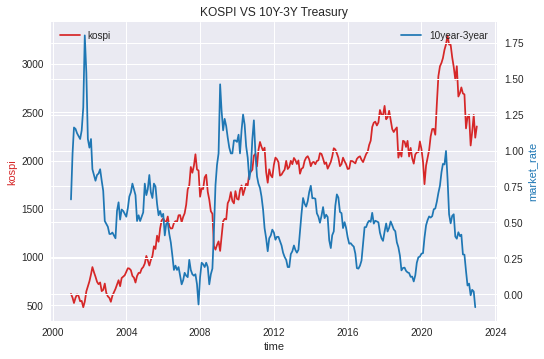

In [85]:
# %% Draw
plt.close('all')
f, ax = plt.subplots(1, 1)
color = 'tab:red'
ax.plot(kospi.index, kospi['종가'], color=color, label='kospi')
ax.set_ylabel('kospi', color=color)
ax.set_xlabel('time')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
# we already handled the x-label with ax1
ax2.set_ylabel('market_rate', color=color)
ax2.plot(market_rate.index,
         market_rate['10year-3year'], color=color, label='10year-3year')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('KOSPI VS 10Y-3Y Treasury')
plt.show()


장단기 금리차는 어떤가? 장단기 금리차 또한 2015년이후에는 코스피에 약간 선행하는것처럼보인다

#### Correlation 분석

In [86]:

df = pd.merge(kospi, market_rate, left_index=True, right_index=True)
df = pd.merge(df, business_indicators, left_index=True, right_index=True)
df = df.dropna()
df = df.sort_index()
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,종가,10year-3year,선행지수순환변동치,동행지수순환변동치
종가,1.000000,-0.344809,0.213931,0.199094
10year-3year,-0.344809,1.000000,0.026837,-0.429200
선행지수순환변동치,0.213931,0.026837,1.000000,0.387917
동행지수순환변동치,0.199094,-0.429200,0.387917,1.000000


빨간색에 가까울수록 Correlation 이 높다. 종가(KOSPI)와 선행지수순환변동치에는 0.213931 이라는 아주 약간의 Correlation이 있고,  장단기 금리차와는 보이지 않는다


2015년 이후만 잘라서 봐보자

In [87]:
after_2015 = df['2015-01-01':]
corr = after_2015.corr()
corr.style.background_gradient(cmap='coolwarm')

,종가,10year-3year,선행지수순환변동치,동행지수순환변동치
종가,1.000000,0.486055,0.617583,0.062081
10year-3year,0.486055,1.000000,0.662613,-0.348933
선행지수순환변동치,0.617583,0.662613,1.000000,0.330845
동행지수순환변동치,0.062081,-0.348933,0.330845,1.000000


장단기 금리차는 0.486055, 선행지수순환변동치는 0.6175 정도가 나왔다. 2015년 이후에는 꽤나 믿을만한 상관계수가 나옴을 알 수 있다.

이번에는 김영익 교수님이 종종 말씀하시는 "장단기 금리차는 코스피에 선행한다" 라는 말을 검증해보자 

In [100]:
def cal_add_month_correlation(kospi, target_df, add_month):
    target_df = copy.deepcopy(target_df)
    target_df.index = target_df.index + \
        pd.DateOffset(months=add_month)
    df = pd.merge(kospi, target_df,
                  left_index=True, right_index=True)
    df = df.dropna()
    df = df.sort_index()
    corr = df.corr()    
    return corr

after_2015_kospi = kospi['2015-01-01':]
after_2015_market_rate = market_rate['2015-01-01':]



In [101]:
correlation = []
for add_month in range(12):
    corr = cal_add_month_correlation(after_2015_kospi, after_2015_market_rate,add_month)
    correlation.append(corr['10year-3year']['종가'])


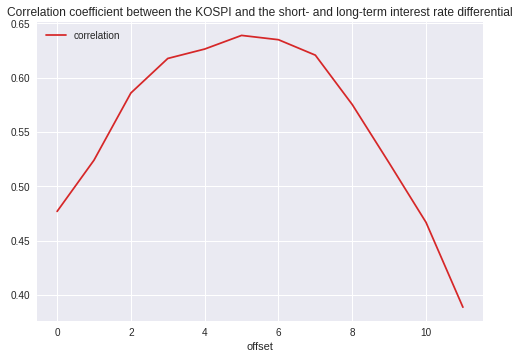

In [106]:
# %% Draw
plt.close('all')
f, ax = plt.subplots(1, 1)
color = 'tab:red'
ax.plot(correlation, color=color, label='correlation')
ax.set_xlabel('offset')
ax.legend(loc='upper left')
plt.title('Correlation coefficient between the KOSPI and the short- and long-term interest rate differential')
plt.show()

장단기 금리차와 코스피와의 상관도는 5개월을 기점으로 하락한다.즉 장단기 금리차는 5개월정도 코스피에 선행하고 있음을 알 수 있다. 

### 결론 

* 장단기 금리차와 선행지수 순환 변동치는 각각 코스피와 2015년 이후에는 어느정도 연관성이 있다. 
* 특히 장단기 금리차는 코스피에 5개월 정도 선행한다. 
* 2022년 12월의 5개월 후인, 2023년 5월 정도에 주식을 사도 좋을 것이다. 